In [1]:
# pytorch
import torch
import torch.nn as nn
# Mobile Net
# from MobileNetV2 import mobilenet_v2
from MobileNetV3 import mobilenetv3_large, mobilenetv3_small
# dataset
from torchvision import datasets
from torchvision import transforms
# dataloader
from torch.utils.data import DataLoader
# Util
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
# tensorboard
from torch.utils.tensorboard import SummaryWriter
# plt
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
matplotlib.rcParams.update({'font.size': 13})
import scipy.io as scio
from scipy.io import loadmat

In [2]:
# loss下降曲线vec
loss_vec4 = []
loss_vec8 = []
loss_vec16 = []
loss_vec32 = []
loss_vec64 = []

In [3]:
# 超参数
input_size = 224
batch_size = 32
n_worker = 8
lr = 0.001
epochs = 50

In [4]:
# 生成训练数据集
train_path = "image/train_image"
test_path = "image/test_image"
# val_path = "Image/val_image"
data_transform = transforms.Compose([
        transforms.Resize([input_size, input_size]),
        transforms.ToTensor(),
])
train_dataset = datasets.ImageFolder(train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(test_path, transform=data_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=data_transform)

In [5]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=20, shuffle=False, 
    num_workers=n_worker)
# val_loader = DataLoader(
    # val_dataset, batch_size=batch_size, shuffle=False, 
    # num_workers=n_worker)

In [6]:
len(test_loader)

90

In [7]:
model = mobilenetv3_large()
# model = mobilenet_v2()
model.classifier[3] = nn.Linear(1280, 90)
model = model.cuda(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
best_model_wts = copy.deepcopy(model.state_dict())
# writer = SummaryWriter()

In [8]:
def train(epoch, model):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(3), label.cuda(3)
        # clear the grad
        optimizer.zero_grad()
        output = model(data)
        # loss function
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # writer.add_scalar("Loss/train", train_loss, epoch)
    loss_vec64.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [9]:
def val(epoch, model):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    # writer.add_scalar("Loss/val", val_loss, epoch)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    # writer.add_scalar("Acc/train", acc, epoch)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [10]:
def test(epoch, model):
    model.eval()
    idx = 0
    ans = 0.0
    best_acc = 0.0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            unique_values, counts = torch.unique(preds, return_counts=True)
            pres = unique_values[counts.argmax()]
            if pres.item() == idx:
                ans += 1
            idx += 1
    acc = ans / 90
    if acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
    print('Epoch: {} Accuracy: {:6f}'.format(epoch, acc))
    return acc

In [11]:
start_time = time.time()
for epoch in range(1, epochs + 1):
    train(epoch, model)
    test(epoch, model)
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Epoch: 1 	Training Loss: 4.128084
Epoch: 1 Accuracy: 0.011111
Epoch: 2 	Training Loss: 3.369933
Epoch: 2 Accuracy: 0.100000
Epoch: 3 	Training Loss: 2.941863
Epoch: 3 Accuracy: 0.200000
Epoch: 4 	Training Loss: 2.664902
Epoch: 4 Accuracy: 0.266667
Epoch: 5 	Training Loss: 2.371099
Epoch: 5 Accuracy: 0.255556
Epoch: 6 	Training Loss: 2.149478
Epoch: 6 Accuracy: 0.388889
Epoch: 7 	Training Loss: 1.839018
Epoch: 7 Accuracy: 0.533333
Epoch: 8 	Training Loss: 1.610886
Epoch: 8 Accuracy: 0.500000
Epoch: 9 	Training Loss: 1.417088
Epoch: 9 Accuracy: 0.522222
Epoch: 10 	Training Loss: 1.292599
Epoch: 10 Accuracy: 0.677778
Epoch: 11 	Training Loss: 1.016511
Epoch: 11 Accuracy: 0.766667
Epoch: 12 	Training Loss: 1.038721
Epoch: 12 Accuracy: 0.722222
Epoch: 13 	Training Loss: 0.765349
Epoch: 13 Accuracy: 0.733333
Epoch: 14 	Training Loss: 0.742942
Epoch: 14 Accuracy: 0.788889
Epoch: 15 	Training Loss: 0.616843
Epoch: 15 Accuracy: 0.777778
Epoch: 16 	Training Loss: 0.632790
Epoch: 16 Accuracy: 0.7

In [54]:
# 计算训练时间
tic = time.time()
train(epoch, model)
toc = time.time()
print(toc - tic)

Epoch: 20 	Training Loss: 0.001821
2.5790278911590576


In [13]:
# 计算测试时间
tic = time.time()
test(1, model)
toc = time.time()
print(toc - tic)

Epoch: 1 Accuracy: 0.675000
2.109910488128662


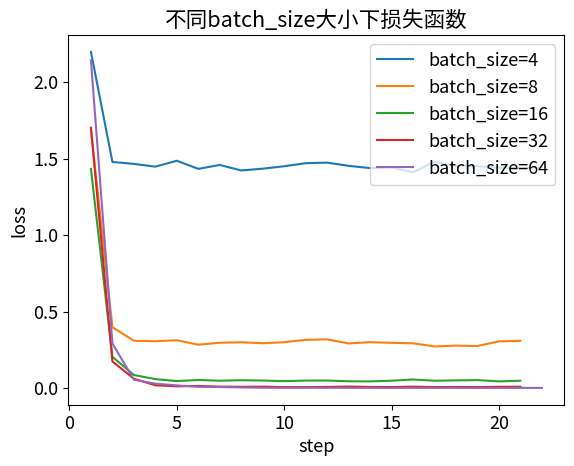

In [63]:
# show train pic
plt.ylabel("loss")
plt.xlabel("step")
plt.title("不同batch_size大小下损失函数")
plt.plot(list(range(1, 23)), loss_vec4, label='batch_size=4')
plt.plot(list(range(1, 22)), loss_vec8, label='batch_size=8')
plt.plot(list(range(1, 22)), loss_vec16, label='batch_size=16')
plt.plot(list(range(1, 22)), loss_vec32, label='batch_size=32')
plt.plot(list(range(1, 23)), loss_vec64, label='batch_size=64')
plt.legend()
plt.show()
# matrix = np.mat([loss_vec4, loss_vec8, loss_vec16, loss_vec32])
# scio.savemat('batch_size.mat', {'data': matrix})

In [12]:
s = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
torch.save(model.load_state_dict(best_model_wts), f'save_model/ecgid_model_{s}.pt')